# Flower classifier 2 layers

_Author: Baccega Sandro_

In this notebook we will classify Oxford's `102 Category Flower Dataset` that can be found [here](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html).

Another required asset to run this code is `Oxford-102_Flower_dataset_labels.txt` from JosephKJ that can be found [here](https://gist.github.com/JosephKJ/94c7728ed1a8e0cd87fe6a029769cde1), this external file contains the flowers names.

---


## Imports and constants


In [425]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
import torch
import shutil
import os
import tqdm
import matplotlib.pyplot as plt
import skimage.io as skio
from tabulate import tabulate
from torch import nn, optim
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
# from torch.autograd import Variable
from torchvision import transforms, models
from torchvision.models import ResNet18_Weights

# --- CONSTANTS AND HYPERPARAMETERS ---

CHOOSEN_MODEL = 1
SEED = 151836
DATASET_SPLIT = 0.8  # Get 80% of dataset for training, the rest for testing

BATCH_SIZE = 64
N_EPOCHS = 8
HIDDEN_LAYERS_OUTPUT_CHANNELS = [8, 16]
CROPPED_IMAGES_SIZE = 200
LEARNING_RATE = 0.001

# Assets location

RAW_IMAGE_LABELS_MAT_FILE = "assets/imagelabels.mat"
RAW_DATASET_LABELS_FILE = "assets/Oxford-102_Flower_dataset_labels.txt"
RAW_DATASET_IMAGES_FOLDER = "assets/jpg"
RAW_SEGMENTED_IMAGES_FOLDER = "assets/segmim"

# Data folder location

DATASET_IMAGES_FOLDER = "data/images"

# Setting seed
torch.manual_seed(SEED)

# Set device to use for computations
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = (
#     "cuda"
#     if torch.cuda.is_available()
#     else ("mps" if torch.backends.mps.is_available() else "cpu")
# )

# Tensorboard writer
writer = SummaryWriter()

print(f"-----\nPyTorch version: {torch.__version__}\nDevice: {device}\n-----")


-----
PyTorch version: 1.13.0.dev20220608
Device: cpu
-----


## Creating the sorted data folder


In [421]:
metadata = pd.DataFrame()
metadata['images'] = sorted(os.listdir(RAW_DATASET_IMAGES_FOLDER))
metadata["labels"] = loadmat(RAW_IMAGE_LABELS_MAT_FILE)["labels"][0] - 1 
metadata['labels'] = metadata['labels'].astype(str)

# print(metadata)

groups = metadata.groupby("labels")["images"].apply(list)

# Creating data folder (ImageFolder dataset)
# If data folder exists, do not create images folder
# if not os.path.isdir(DATASET_IMAGES_FOLDER):
#     print("Creating data folder")
#     os.mkdir(DATASET_IMAGES_FOLDER)

#     for category, images in groups.items():
#         os.mkdir("{}/{}".format(DATASET_IMAGES_FOLDER, category))
#         for image in images:
#             shutil.copyfile(
#                 "{}/{}".format(RAW_DATASET_IMAGES_FOLDER, image),
#                 "{}/{}/{}".format(DATASET_IMAGES_FOLDER, category, image),
#             )

#     print("Done - data folder creation")
# else:
#     print("Skipping - data folder creation")


# Creating category to label reference
rawLabelReferenceData = np.loadtxt(RAW_DATASET_LABELS_FILE, dtype="str", delimiter="\n")
labelReferenceData = list(map(lambda str: str[2:-1], rawLabelReferenceData))

i = 0
labelReference = {}

for category, images in groups.items():
    labelReference[category] = labelReferenceData[i]
    i += 1

print("Done - label reference creation")
# print(labelReference)


Done - label reference creation


## Creating the datasets


Train dataset size: 6551
Test dataset size: 1638


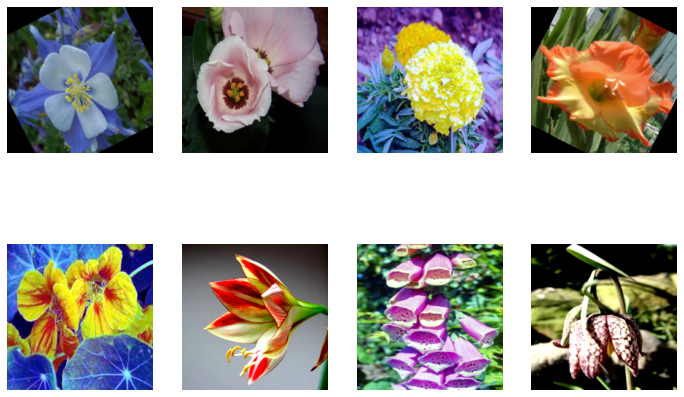

In [422]:
class FlowerDateset(Dataset):
    def __init__(self, metadata, transform=None):
        self.metadata = metadata
        self.transform = transform

    def __getitem__(self, index):
        image_path = self.metadata.iloc[index, 0]
        image = skio.imread("{}/{}".format(RAW_DATASET_IMAGES_FOLDER, image_path))
        label = torch.tensor(int(self.metadata.iloc[index, 1]))
        label = F.one_hot(label, num_classes=102)
        label = label.float()
        if self.transform:
            image = self.transform(image)

        return (image, label)

    def __len__(self):
        return len(self.metadata)


transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        # transforms.RandomRotation(45),
        # transforms.RandomHorizontalFlip(),
        transforms.Resize((CROPPED_IMAGES_SIZE, CROPPED_IMAGES_SIZE)),
        # transforms.RandomCrop(CROPPED_IMAGES_SIZE),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.AutoAugment(),
        transforms.ToTensor()
    ]
)


dataset = FlowerDateset(metadata, transform=transform)

train_set_size = int(len(dataset) * DATASET_SPLIT)
test_set_size = len(dataset) - train_set_size

train_dataset, test_dataset = data.random_split(
    dataset, [train_set_size, test_set_size]
)

train_dataloader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True
)

print("Train dataset size: {}".format(len(train_dataset)))
print("Test dataset size: {}".format(len(test_dataset)))

n_rows = 2
n_cols = 4

for x, y in train_dataloader:
    x = x.to(device)
    fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 8))
    for i in range(n_rows):
        for j in range(n_cols):
            ax[i, j].imshow(x[(i * n_cols) + j].cpu().permute(1,2,0))
            ax[i, j].axis("off")
            #ax[i, j].set_title(labelReference[label])
    break


## Creating the model

Here we create our CNN model with 2 simple layers or use the ResNet18 model.

We use a kernel_size=(3,3), stride=(1,1) and padding=(1,1) in order to have a same convolution (manteins image size).

We use a MaxPool2d to reduce the size of the network by half efficiently.

We use a Linear to create the last fully connected layer.  

We use the Adam optimizer and the CrossEntropyLoss as our loss function.


In [423]:
class My2LayerCNN(nn.Module):
    def __init__(
        self,
        num_in_channels=3,
        num_out_channels=HIDDEN_LAYERS_OUTPUT_CHANNELS,
        img_width=CROPPED_IMAGES_SIZE,
        img_height=CROPPED_IMAGES_SIZE,
        num_classes=102,
    ):
        super(My2LayerCNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=num_in_channels,
            out_channels=num_out_channels[0],
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.conv2 = nn.Conv2d(
            in_channels=num_out_channels[0],
            out_channels=num_out_channels[1],
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.fc = nn.Linear(
            in_features=int(img_width / 4) * int(img_height / 4) * num_out_channels[1],
            out_features=num_classes,
        )

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.fc(x.reshape(x.shape[0], -1))
        return x


# Load saved model
# model = My2LayerCNN(*args, **kwargs)
# model.load_state_dict(torch.load(PATH))
# model.eval()

# My 2 Layer CNN model
if CHOOSEN_MODEL == 1:
    model = My2LayerCNN()
# Resnet
if CHOOSEN_MODEL == 2:
    model = models.resnet18()
    model.fc = nn.Linear(model.fc.in_features, 102)
# Resnet pretrained
if CHOOSEN_MODEL == 3:
    model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, 102)


model = model.to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Loss function
criterion = nn.CrossEntropyLoss()


/opt/homebrew/Caskroom/miniconda/base/envs/pytorch-nightly/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/pytorch-nightly/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/sandrobaccega/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

## Train model


In [424]:
training_results_data = pd.DataFrame(
    {"Epoch": [], "Predictions": [], "Samples": [], "Accuracy": [], "Loss": []}
)

def check_accuracy(data_loader, model):
    n_corrects = 0
    n_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in data_loader:
            # Sending data to device
            x = x.to(device)
            y = y.to(device)

            # Forward propagation
            y_hat = model(x)

            # Calculate accuracy
            _, labels = y.max(1)
            _, predictions = y_hat.max(1)
            n_corrects += (predictions == labels).sum()
            n_samples += predictions.size(0)

        perc = (n_corrects.item() / n_samples) * 100
        return (n_corrects.item(), n_samples, perc)


model.train()
for epoch in range(N_EPOCHS):
    running_loss = 0
    with tqdm.tqdm(train_dataloader, unit="batch") as tepoch:

        for index, (x, y) in enumerate(tepoch):
            # Send the data to the device
            x = x.to(device)
            y = y.to(device)

            # Forward propagation
            y_hat = model(x)
            loss = criterion(y_hat, y)
            running_loss += loss

            # Backward propagation
            optimizer.zero_grad()
            # Calculate derivatives for every parameters
            loss.backward()
            # Do gradient descent
            optimizer.step()
            tepoch.set_postfix(loss=loss.item())

        print(f"Epoch {epoch + 1}, loss: {running_loss}")
        # print(f"Accuracy: {n_corrects}/{n_samples} = {perc:.2f}%")
        n_corrects, n_samples, accuracy = check_accuracy(test_dataloader, model)
        training_results_data.loc[len(training_results_data.index)] = [
            int(epoch + 1),
            int(n_corrects),
            int(n_samples),
            accuracy,
            running_loss.item(),
        ]
        writer.add_scalar("Loss/train", running_loss, epoch)
        writer.add_scalar('Accuracy/test', accuracy, epoch)

writer.flush()
writer.close()

# Saving model
torch.save(model.state_dict(), 'model.pt')

# Saving parameters
with open('model_parameters.txt', 'w') as file:
        file.write(f"SEED = {SEED}\n")
        file.write(f"DATASET_SPLIT = {DATASET_SPLIT}\n")
        file.write(f"BATCH_SIZE = {BATCH_SIZE}\n")
        file.write(f"N_EPOCHS = {N_EPOCHS}\n")
        file.write(f"HIDDEN_LAYERS_OUTPUT_CHANNELS = {HIDDEN_LAYERS_OUTPUT_CHANNELS}\n")
        file.write(f"CROPPED_IMAGES_SIZE = {CROPPED_IMAGES_SIZE}\n")
        file.write(f"LEARNING_RATE = {LEARNING_RATE}\n")

 17%|█▋        | 18/103 [01:13<05:48,  4.10s/batch, loss=2.63]


KeyboardInterrupt: 

## Results

╒═════════╤═══════════════════════╤════════════╤═════════╕
│   Epoch │ Predictions/Samples   │ Accuracy   │    Loss │
╞═════════╪═══════════════════════╪════════════╪═════════╡
│       1 │ 139/1638              │ 8.49%      │ 465.279 │
├─────────┼───────────────────────┼────────────┼─────────┤
│       2 │ 193/1638              │ 11.78%     │ 408.442 │
├─────────┼───────────────────────┼────────────┼─────────┤
│       3 │ 271/1638              │ 16.54%     │ 361.869 │
├─────────┼───────────────────────┼────────────┼─────────┤
│       4 │ 298/1638              │ 18.19%     │ 306.607 │
├─────────┼───────────────────────┼────────────┼─────────┤
│       5 │ 369/1638              │ 22.53%     │ 248.79  │
├─────────┼───────────────────────┼────────────┼─────────┤
│       6 │ 368/1638              │ 22.47%     │ 202.188 │
├─────────┼───────────────────────┼────────────┼─────────┤
│       7 │ 398/1638              │ 24.30%     │ 168.923 │
├─────────┼───────────────────────┼────────────┼────────

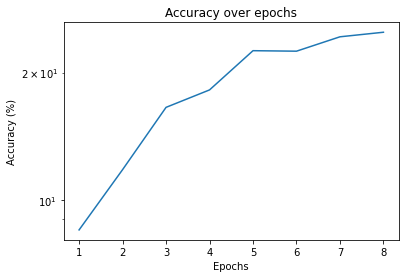

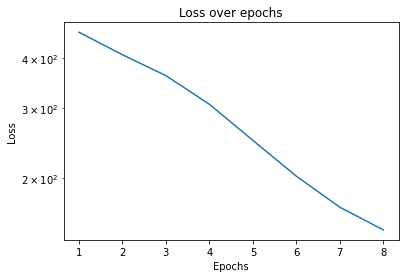

In [ ]:
# Pre-made data
# training_results_data = pd.DataFrame(
#     {
#         "Epoch": [1, 2, 3, 4, 5, 6, 7, 8],
#         "Predictions": [503, 576, 597, 620, 626, 633, 636, 637],
#         "Samples": [1638, 1638, 1638, 1638, 1638, 1638, 1638, 1638],
#         "Accuracy": [30.71, 35.16, 36.45, 37.85, 38.22, 38.64, 38.83, 38.89],
#         "Loss": [
#             393.67,
#             141.599,
#             25.4623,
#             3.54714,
#             1.30103,
#             1.12792,
#             0.359285,
#             0.998295,
#         ],
#     }
# )

formatted_training_results_data = pd.DataFrame(
    {"Epoch": [], "Predictions/Samples": [], "Accuracy": [], "Loss": []}
)
for index, row in training_results_data.iterrows():
    formatted_training_results_data.loc[len(formatted_training_results_data.index)] = [
            row[0],
            f"{int(row[1])}/{int(row[2])}",
            f"{row[3]:.2f}%",
            f"{row[4]}",
        ]

print(tabulate(formatted_training_results_data, headers = 'keys', tablefmt = 'fancy_grid', showindex="never"))


plt.plot(training_results_data["Epoch"], training_results_data["Accuracy"])
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.yscale('log')
# plt.grid(True)
plt.show()

plt.plot(training_results_data["Epoch"], training_results_data["Loss"])
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
# plt.grid(True)
plt.show()